In [1]:
import numpy as np
from matplotlib import pyplot as plt



In [25]:
class RBFnetwork(object):
    def __init__(self, hidden_nums, lr_w, lr_c, lr_sigma):
        self.n_hiddens = hidden_nums       #隐含层神经元个数
        self.weight = None                  #线性权值
        self.c = None                  #神经元中心点
        self.sigma = None              #高斯核宽度
        self.r = {"w":lr_w, 
                  "c":lr_c, 
                  "sigma":lr_sigma}  #参数迭代的学习率
        self.errList = []           #误差列表
        self.tol = 1.0e-5           #最大容忍误差
        
        self.n_samples = 0          #训练集样本数量
        self.n_features = 0         #训练集特征数量
        
    #计算径向基距离函数
    def guass(self, sigma, X, ci):
        return np.exp(-np.linalg.norm((X-ci), axis=1)**2/(2*sigma**2))

    #将原数据高斯转化成新数据
    def change(self, sigma, X, c):
        newX = np.zeros((self.n_samples, self.n_hiddens))
        for i in range(self.n_hiddens):
            newX[:,i] = self.guass(sigma[i], X, c[i])
        return newX

    #初始化参数
    def init(self):
        sigma = np.random.random((self.n_hiddens, 1))               #(h,1)
        c = np.random.random((self.n_hiddens, self.n_features))     #(h,n)
        w = np.random.random((self.n_hiddens+1, 1))                 #(h+1,1)
        return sigma, c, w

    #给输出层的输入加一列截距项
    def addIntercept(self, X):
        return np.hstack((X,np.ones((self.n_samples,1))))

    #计算整体误差
    def calSSE(self, prey, y):
        return 0.5*(np.linalg.norm(prey - y))**2

    #求L2范数的平方 (sum_square)
    def l2(self, X:np.ndarray, c):
        m,n = X.shape
        newX = np.zeros((m, len(c)))
        for i in range(len(c)):
            newX[:,i] = np.linalg.norm((X-c[i]), axis=1)**2
        return newX
    #训练
    def fit(self, X:np.ndarray, y:np.ndarray, epoches)->None:
        y =  y.reshape(-1,1)
        self.n_samples, self.n_features = X.shape
        
        self.sigma, self.c, self.weight = self.init()       #初始化参数
        
        for epoch in range(epoches):
            # 正向计算过程
            hi_output = self.change(self.sigma, X, self.c)              #隐含层输出(m,h)，即通过径向基函数的转换
            yi_input = self.addIntercept(hi_output)         #输出层输入(m,h+1)，因为是线性加权，故将偏置加入
            yi_output = np.dot(yi_input, self.weight)                 #输出预测值(m,1)
            
            error = self.calSSE(yi_output, y)               #计算误差
            if error < self.tol:
                break
            self.errList.append(error)                      #保存误差
            # 误差反向传播过程
            delta_w = np.dot(yi_input.T, (yi_output-y))      #(h+1,m)x(m,1)
            self.weight -= self.r['w'] * delta_w/self.n_samples
            
            delta_sigma = np.divide(np.multiply(np.dot(np.multiply(hi_output,self.l2(X, self.c)).T,
                        (yi_output-y)), self.weight[:-1]), self.sigma**3)  #(h,m)x(m,1)
            self.sigma -= self.r['sigma'] * delta_sigma / self.n_samples
            
            deltac1 = self.weight[:-1] / (self.sigma**2)            #(hidden,1)
            
            deltac2 = np.zeros((1,self.n_features))               #(1,batch)
            for j in range(self.n_samples):
                deltac2 += (yi_output-y)[j] * np.dot(hi_output[j], X[j] - self.c)
            
            delta_c = np.dot(deltac1, deltac2)                #(h,1)x(1,n)
            self.c -= self.r['c']*delta_c/self.n_samples
        
    #预测
    def predict(self, X):
        hi_output = self.change(self.sigma,X,self.c)    #隐含层输出(batch,hidden)，即通过径向基函数的转换
        yi_input = self.addIntercept(hi_output)         #输出层输入(batch, hidden+1)，因为是线性加权，故将偏置加入
        yi_output = np.dot(yi_input, self.weight)            #输出预测值(m,1)
        return yi_output
    
X = np.linspace(-5, 5 , 500)[:, np.newaxis]
y = np.multiply(1.1*(1-X+2*X**2), np.exp(-0.5*X**2))
rbf = RBFnetwork(50, 0.1, 0.2, 0.1)
rbf.fit(X, y, 500)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


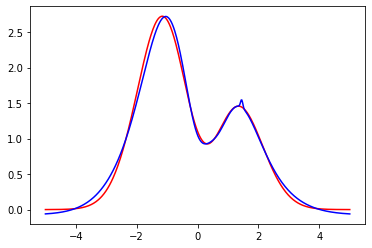

In [12]:

plt.plot(X,y,color='r')
plt.plot(X,rbf.predict(X),color='b') 